In [2]:
import pandas as pd
import plotly.express as px # For colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# l_cols = ['time_run', 'seconds_uptime', 'cpu_last_1min', 'cpu_last_5min', 'cpu_last_15min', 
#           'time_most_recent_python_file', 'time_most_recent_kernel_activity']
# df = pd.read_csv('./data/activity_signals.csv', names=l_cols, header=None, na_values=['None'])

In [10]:
l_cols = ['time_run', 'seconds_uptime', 'cpu_last_5min', 'tmra_files', 'tmra_jup_sessions', 'tmra_jup_terminals']
df = pd.read_csv('/opt/vm-auto-shutdown/data/activity_signals.csv', names=l_cols, header=None, na_values=['None'])

In [12]:
# Post-processing :
df['utc_datetime_run'] = pd.to_datetime(df.time_run, unit='s')
# 'sMRA' = 'Seconds since Most Recent Activity'
df['smra_files']         = df.time_run - df.tmra_files
df['smra_jup_sessions']  = df.time_run - df.tmra_jup_sessions
df['smra_jup_terminals'] = df.time_run - df.tmra_jup_terminals

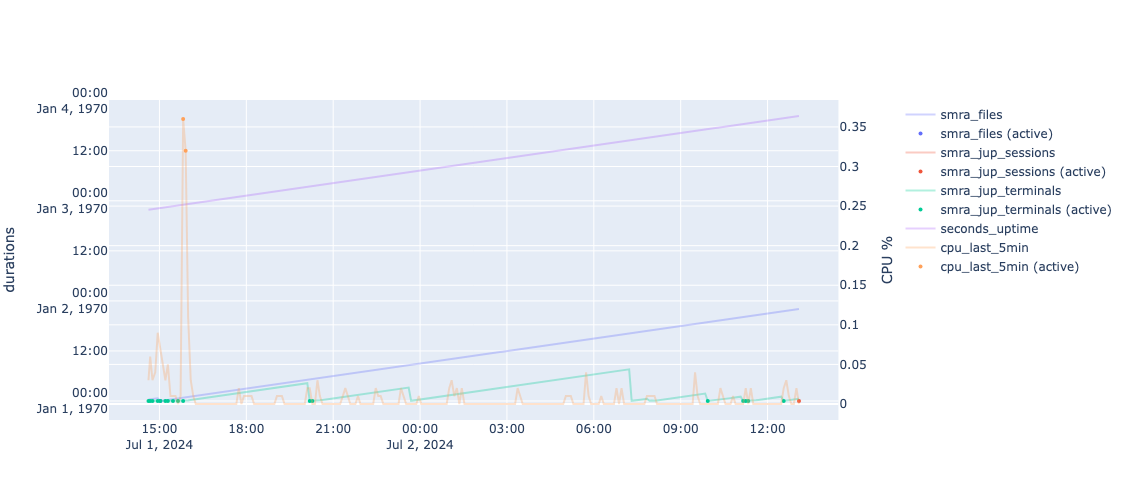

In [13]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

L_COLORS = px.colors.qualitative.Plotly
i_color = 0

def line_and_markers(name, s_y, color, mask, secondary_y) :
    fig.add_trace(
        go.Scatter(x=df['utc_datetime_run'], y=s_y, name=name, 
                   line_color=color, opacity=.3, marker=dict(size=1)),
        secondary_y=secondary_y,
    )
    fig.add_trace(
        go.Scatter(x=df.loc[mask,'utc_datetime_run'], y=s_y.loc[mask], name=f'{kpi} (active)',
                   marker_color=color, mode='markers', marker=dict(size=4)),
        secondary_y=secondary_y,
    )
    
# Primariy Y axis
for kpi, t in {
    'smra_files': 2*60, 
    'smra_jup_sessions': 2*60,
    'smra_jup_terminals': 2*60, 
    'seconds_uptime': 2*60}.items() :
    line_and_markers(kpi, pd.to_datetime(df[kpi], unit='s'), L_COLORS[i_color], df[kpi]<t, False)
    i_color += 1
    
# Secondary Y axis
for kpi, t in {'cpu_last_5min': .25}.items() :
    line_and_markers(kpi, df[kpi], L_COLORS[i_color], df[kpi]>t, True)
    i_color += 1

# Set y-axes titles
fig.update_yaxes(title_text='durations', secondary_y=False)
fig.update_yaxes(title_text='CPU %', secondary_y=True)
fig.update_layout(height=500)
fig.show()

In [52]:
# These are the timeout_duration "x" ==> "At this rate, it would take x hours to shutdown the machine"
# We will cumulate by the INVERT (1/x) of this duration. We keep duration here for easier interpretation.
# Time in Switzerland :  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0,  1
# Time in UTC         :  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
L_TIMEOUT_BY_UTC_HOUR = [1,  1,  1,  1,  1,  1,  3,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  4,  3,  2,  2, 1]